In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

import joblib

In [2]:
fecha = '2024_03_10'
corte_perdida_cosecha = 0.0

In [3]:
data = pd.read_csv(f"./data/master/data_{fecha}_master.csv")

In [11]:
data.columns

Index(['id_distribuidor', 'id_red', 'id_operacion', 'perdida_cosecha',
       'dependientes', 'tiempo_vivienda', 'ingreso_neto', 'tipo_negocio',
       'tiempo_op_negocio', 'edad', 'folio', 'creditos_con_claves_prevencion',
       'creditos_completados_con_atraso', 'saldo_vencido_total',
       'pagos_vencidos', 'creditos_totales', 'estado_distrito_federal',
       'estado_jalisco', 'estado_mexico', 'estado_tabasco',
       'estado_veracruz_de_ignacio_de_la_llave', 'sucursal_cardenas',
       'sucursal_chalco', 'sucursal_chimalhuacan_2', 'sucursal_coatzacoalcos',
       'sucursal_fortin', 'sucursal_ixtapaluca', 'sucursal_ixtapaluca_2',
       'sucursal_nezahualcoyotl_2', 'sucursal_orizaba', 'sucursal_texcoco',
       'sucursal_tonala', 'sucursal_tonala_2', 'sucursal_villahermosa',
       'escolaridad_bachillerato', 'escolaridad_licenciatura',
       'escolaridad_otro', 'escolaridad_primaria', 'escolaridad_secundaria',
       'escolaridad_sin_estudios', 'escolaridad_tecnico',
       'es

In [4]:
n = data.shape[0]

0 mal pagador

1 buen pagador

In [5]:
data['target'] = 0

data.target[data.perdida_cosecha <= corte_perdida_cosecha] = 1
data.target[data.perdida_cosecha > corte_perdida_cosecha] = 0

In [6]:
data.target.value_counts()

0    17082
1     7677
Name: target, dtype: int64

# Prestamo personal red

In [7]:
data_red = data.query("tipo_prestamo == 'prestamo_personal_red'")
data_red_original = data_red.copy()
print(data_red.target.value_counts())
data_red.drop(["tipo_prestamo", "perdida_cosecha"], axis = 1, inplace=True)

1    6526
0    1183
Name: target, dtype: int64


In [8]:
data_red.drop(["id_distribuidor", 'id_red', 'id_operacion', 'folio'], axis = 1, inplace=True)

In [9]:
data_red.shape

(7709, 51)

In [78]:
# Guardando el orden de las columnas

# Guardar la lista de strings en un archivo de texto usando numpy
np.savetxt('./data/master/columnas_usar.txt', np.array(data_red.drop('target', axis = 1).columns), fmt='%s')

# Leer la lista de strings desde el archivo
lista_leida = np.loadtxt('./data/master/columnas_usar.txt', dtype=str)


**Probando diversos algoritmos**

In [21]:

def probar_varios_algoritmos(datos, variable_objetivo, test_size=0.2, random_state=42):
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import make_scorer, f1_score

    # Supongamos que tienes un clasificador llamado 'modelo' y tus datos son X e y

    # Definir la función de puntuación con F1-score para la clase negativa
    f1_negativo_scorer = make_scorer(f1_score, pos_label=0)
    
    # Separar las características (X) y la variable objetivo (y)
    X = datos.drop(variable_objetivo, axis=1)
    y = datos[variable_objetivo]

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Inicializar varios modelos
    modelos = {
        'Regresión Logística': LogisticRegression(class_weight='balanced'),
        'K Vecinos más Cercanos': KNeighborsClassifier(),
        'Árbol de Decisión': DecisionTreeClassifier(class_weight='balanced'),
        'Random Forest': RandomForestClassifier(class_weight='balanced'),
        'SVM': SVC(class_weight='balanced')
    }

    # Evaluar cada modelo utilizando validación cruzada
    resultados = {}
    for nombre, modelo in modelos.items():
        scores = cross_val_score(modelo, X_train, y_train, cv=4, scoring=f1_negativo_scorer)
        print(f"{nombre} - {np.mean(scores)}")
        resultados[nombre] = {'F1-score medio': np.mean(scores), 'Desviación estándar': np.std(scores)}

    # Entrenar y evaluar el mejor modelo en el conjunto de prueba
    mejor_modelo_nombre = max(resultados, key=lambda x: resultados[x]['F1-score medio'])
    mejor_modelo = modelos[mejor_modelo_nombre]
    mejor_modelo.fit(X_train, y_train)
    y_pred = mejor_modelo.predict(X_test)
    f1_test = f1_score(y_test, y_pred, pos_label=1)
    
    return resultados, mejor_modelo_nombre, f1_test


In [22]:
probar_varios_algoritmos(data_red, "target", test_size=0.2, random_state = 666)

Regresión Logística - 0.3463074407160549
K Vecinos más Cercanos - nan
Árbol de Decisión - 0.17613012722444624


KeyboardInterrupt: 

**Optimizando una LR**

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score

X = data_red.drop("target", axis=1)
y = data_red["target"]
# Definir la función de puntuación con F1-score para la clase negativa
f1_negativo_scorer = make_scorer(f1_score, pos_label=0)

# Crear un clasificador de Regresión Logística
modelo = LogisticRegression(class_weight='balanced')

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],  # Algoritmo de optimización
    'max_iter': [100, 200, 300]  # Número máximo de iteraciones
}

# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=5, scoring=f1_negativo_scorer, verbose = 1)
grid_search.fit(X, y)

# Imprimir los mejores hiperparámetros y el mejor F1-score negativo
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor F1-score negativo:", grid_search.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores hiperparámetros: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Mejor F1-score negativo: 0.3422501234743758


**Pendiente, más pruebas de algoritmos**

In [125]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import uniform, randint

# Definir la función de puntuación con F1-score para la clase negativa
f1_negativo_scorer = make_scorer(f1_score, pos_label=0)

# Crear un clasificador SVM
modelo = SVC(class_weight='balanced')

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'C': uniform(0.001, 100),  # Parámetro de regularización
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel
    'gamma': ['scale', 'auto'],  # Parámetro gamma
    'degree': randint(2, 5),  # Grado del polinomio (solo para kernel 'poly')
}

# Realizar la búsqueda de hiperparámetros utilizando RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_dist, n_iter=5, cv=2, scoring=f1_negativo_scorer,
                                  verbose = 2)
random_search.fit(X, y)

# Imprimir los mejores hiperparámetros y el mejor F1-score negativo
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor F1-score negativo:", random_search.best_score_)




Fitting 2 folds for each of 5 candidates, totalling 10 fits


KeyboardInterrupt: 

**Logistic Regression resultó el mejor modelo**

In [76]:
X = data_red.drop("target", axis=1)
y = data_red["target"]
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)

modelo = LogisticRegression(class_weight='balanced')
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
f1_score(y_test, y_pred)

joblib.dump(modelo, './data/processed/modelo_regresion_logistica.pkl')

['./data/processed/modelo_regresion_logistica.pkl']

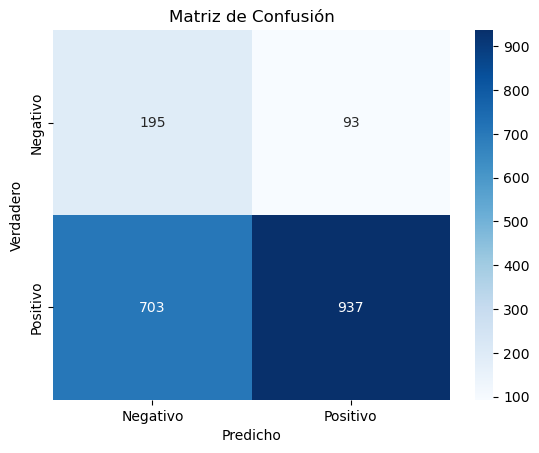

In [84]:
matriz_confusion = confusion_matrix(y_test, y_pred)
# Plotear la matriz de confusión
sns.heatmap(matriz_confusion, annot=True, cmap='Blues', fmt='d', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [85]:
probs = modelo.predict_proba(X).T[1]
cut = 0.459
probs[probs > cut] = 1
probs[probs <= cut] = 0
f1_score(probs, y, pos_label=1)

0.7883451495763445

In [86]:
data_red_original['probabilidad'] = modelo.predict_proba(X).T[0]
data_red_original['target_predicted'] = probs

(array([ 419.,  315.,  809., 1327., 1197., 1527., 1137.,  675.,  278.,
          25.]),
 array([0.0284213 , 0.11961713, 0.21081295, 0.30200878, 0.3932046 ,
        0.48440043, 0.57559626, 0.66679208, 0.75798791, 0.84918374,
        0.94037956]),
 <BarContainer object of 10 artists>)

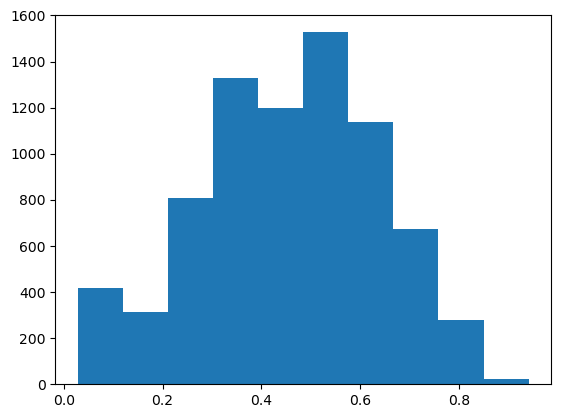

In [87]:
plt.hist(data_red_original['probabilidad'])

In [88]:
deciles = np.percentile(data_red_original['probabilidad'], np.arange(0, 101, 10))

# Imprimir los deciles
print("Deciles:", deciles)

Deciles: [0.0284213  0.21800037 0.30190946 0.35270743 0.41233056 0.468175
 0.51639213 0.56136935 0.61865237 0.68684592 0.94037956]


In [89]:
#guardando los deciles
np.savetxt('./data/master/deciles.txt', deciles, fmt='%s')

In [90]:
data_red_original['grupo_riesgo'] = pd.qcut(data_red_original['probabilidad'], q = 10, labels=False)

In [91]:
data_red_original.groupby("grupo_riesgo").target.sum()

grupo_riesgo
0    755
1    724
2    696
3    691
4    677
5    664
6    637
7    625
8    566
9    491
Name: target, dtype: int64

In [92]:
np.array(data_red_original.groupby("grupo_riesgo").perdida_cosecha.mean())

array([0.00598185, 0.01829813, 0.0332206 , 0.0311605 , 0.03374105,
       0.03977056, 0.05243911, 0.05828372, 0.07900052, 0.1122694 ])

In [93]:
#guardando los las pérdidas estimadas
np.savetxt('./data/master/perdida_cosecha.txt', np.array(data_red_original.groupby("grupo_riesgo").perdida_cosecha.mean()), fmt='%s')

In [20]:
data_red_original

,id_distribuidor,id_red,id_operacion,perdida_cosecha,dependientes,tiempo_vivienda,ingreso_neto,tipo_negocio,tiempo_op_negocio,edad,...,tipo_vivienda_rentada,sexo_femenino,sexo_masculino,experiencia_no,experiencia_si,tipo_prestamo,target,probabilidad,target_predicted,grupo_riesgo
0,100002,100399,100400,0.000000,2.922441,-0.840328,0.001789,-0.840328,0.331977,-0.331258,...,0,1,0,1,0,prestamo_personal_red,1,0.638664,0.0,8
3,100002,130927,130928,0.000000,2.922441,-0.840328,0.001789,-0.840328,0.331977,-0.331258,...,0,1,0,1,0,prestamo_personal_red,1,0.638664,0.0,8
6,100002,139856,139857,0.132363,2.922441,-0.840328,0.001789,-0.840328,0.331977,-0.331258,...,0,1,0,1,0,prestamo_personal_red,0,0.638664,0.0,8
8,100011,101435,101439,0.411307,-0.781247,2.668750,-0.066100,2.668750,0.331977,-1.512758,...,0,1,0,1,0,prestamo_personal_red,0,0.852997,0.0,9
9,100016,101435,101441,0.411307,1.996519,2.668750,-0.002961,2.668750,-0.117230,-1.040158,...,0,1,0,1,0,prestamo_personal_red,0,0.833150,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,99975,132601,132602,0.000000,1.070597,-0.840328,0.016989,-0.840328,-0.566437,-0.094958,...,0,1,0,1,0,prestamo_personal_red,1,0.508745,1.0,5
24755,99987,100399,100404,0.000000,1.996519,0.663563,0.011289,0.663563,-0.566437,-0.803858,...,0,1,0,1,0,prestamo_personal_red,1,0.604432,0.0,7
24756,99993,100399,100401,0.000000,-0.781247,-0.339031,0.001789,-0.339031,0.331977,2.110508,...,0,1,0,1,0,prestamo_personal_red,1,0.553865,0.0,6
24757,99993,130927,130929,0.000000,-0.781247,-0.339031,0.001789,-0.339031,0.331977,2.110508,...,0,1,0,1,0,prestamo_personal_red,1,0.553865,0.0,6


Cruzando con raw, para saber la 

In [21]:
data_red_raw = pd.read_csv("./data/raw/data_comportamiento_2024_03_10_raw.csv")
data_red_raw = data_red_raw[['id_operacion', 'id_red', 'id_distribuidor', 'capital_pagado', 'capital_pendiente', 'capital']]

data_analisis = data_red_original.merge(data_red_raw, on = ['id_operacion', 'id_red', 'id_distribuidor'])

In [27]:
grupos_riesgo = data_analisis.groupby("grupo_riesgo").capital.sum() / data_analisis.groupby("grupo_riesgo").capital_pagado.sum() - 1

In [33]:
grupos_riesgo

grupo_riesgo
0    0.003694
1    0.014365
2    0.025861
3    0.030818
4    0.028897
5    0.031662
6    0.047387
7    0.058936
8    0.084683
9    0.116722
dtype: float64

In [34]:
data_analisis['perdida_cosecha_estimada'] = data_analisis.grupo_riesgo.apply(lambda x: grupos_riesgo[x])

In [35]:
data_analisis.to_csv("./data/processed/data_2024_03_10_processed.csv", index=False)

In [36]:
data_analisis

,id_distribuidor,id_red,id_operacion,perdida_cosecha,dependientes,tiempo_vivienda,ingreso_neto,tipo_negocio,tiempo_op_negocio,edad,...,experiencia_si,tipo_prestamo,target,probabilidad,target_predicted,grupo_riesgo,capital_pagado,capital_pendiente,capital,perdida_cosecha_estimada
0,100002,100399,100400,0.000000,2.922441,-0.840328,0.001789,-0.840328,0.331977,-0.331258,...,0,prestamo_personal_red,1,0.638664,0.0,8,83000.01,0.00,83000.01,0.084683
1,100002,130927,130928,0.000000,2.922441,-0.840328,0.001789,-0.840328,0.331977,-0.331258,...,0,prestamo_personal_red,1,0.638664,0.0,8,195000.06,0.00,195000.06,0.084683
2,100002,139856,139857,0.132363,2.922441,-0.840328,0.001789,-0.840328,0.331977,-0.331258,...,0,prestamo_personal_red,0,0.638664,0.0,8,169189.21,25810.80,195000.01,0.084683
3,100011,101435,101439,0.411307,-0.781247,2.668750,-0.066100,2.668750,0.331977,-1.512758,...,0,prestamo_personal_red,0,0.852997,0.0,9,33575.60,23458.58,57034.18,0.116722
4,100016,101435,101441,0.411307,1.996519,2.668750,-0.002961,2.668750,-0.117230,-1.040158,...,0,prestamo_personal_red,0,0.833150,0.0,9,33575.60,23458.58,57034.18,0.116722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7704,99975,132601,132602,0.000000,1.070597,-0.840328,0.016989,-0.840328,-0.566437,-0.094958,...,0,prestamo_personal_red,1,0.508745,1.0,5,284000.06,0.00,284000.06,0.031662
7705,99987,100399,100404,0.000000,1.996519,0.663563,0.011289,0.663563,-0.566437,-0.803858,...,0,prestamo_personal_red,1,0.604432,0.0,7,83000.01,0.00,83000.01,0.058936
7706,99993,100399,100401,0.000000,-0.781247,-0.339031,0.001789,-0.339031,0.331977,2.110508,...,0,prestamo_personal_red,1,0.553865,0.0,6,83000.01,0.00,83000.01,0.047387
7707,99993,130927,130929,0.000000,-0.781247,-0.339031,0.001789,-0.339031,0.331977,2.110508,...,0,prestamo_personal_red,1,0.553865,0.0,6,195000.06,0.00,195000.06,0.047387


In [40]:
np.mean(np.abs(data_analisis.perdida_cosecha - data_analisis.perdida_cosecha_estimada))

0.07194734037832232

<Axes: ylabel='Feature'>

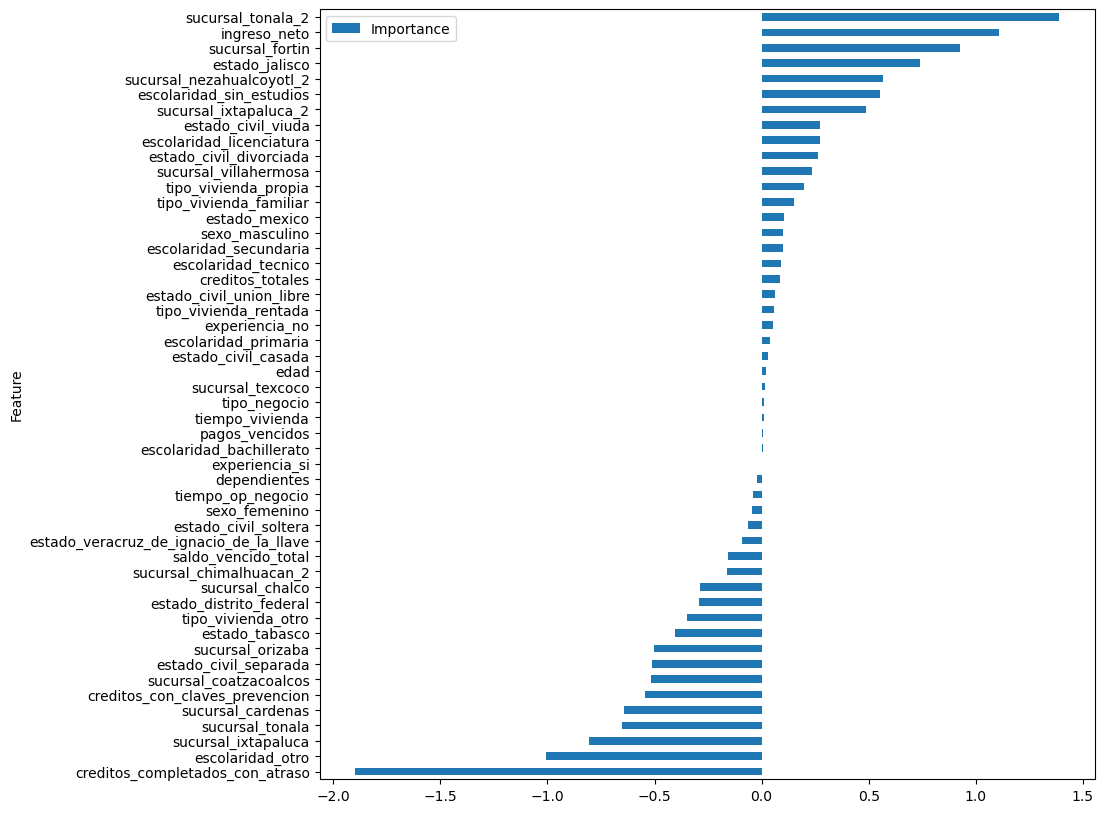

In [48]:

coefficients = modelo.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10))

In [55]:
data_analisis.query("sucursal_cardenas == 1").perdida_cosecha.mean()

0.12249202701529036

In [ ]:
data_analisis.sucu